In [108]:
import os, subprocess, time, json, shutil, glob, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Paths
ROOT = Path("/Users/georgezhou/personal/research/serverless-jit")
JDK = ROOT/"jdk25u"/"build"/"macosx-aarch64-server-release"/"images"/"jdk"
JAVA = JDK/"bin"/"java"
JAVAC = JDK/"bin"/"javac"
BENCH = ROOT/"bench"

assert JAVA.exists(), f"JAVA not found: {JAVA}"
assert JAVAC.exists(), f"JAVAC not found: {JAVAC}"

os.chdir(BENCH)
print(f"Working dir: {Path.cwd()}")

# Compile benchmark if needed
subprocess.run([str(JAVAC), "WordCountBenchmark.java"], check=True)

# Clean previous outputs
for p in glob.glob("*.csv") + glob.glob("*.aot") + glob.glob("*.aotconfig") + glob.glob("hotspot_pid*.log"):
    try:
        os.remove(p)
    except FileNotFoundError:
        pass

print("Env ready.")


Working dir: /Users/georgezhou/personal/research/serverless-jit/bench
Env ready.


In [109]:
# Phase 1: training run → write AOT configuration + AOT cache (assembly)
# We use new AOT flags (JEP 483 style). Two-step flow:
#  - record: create a .aotconfig with training data
#  - create: assemble .aot from the .aotconfig

AOT_CONFIG = "wordcount.aotconfig"
AOT_CACHE  = "wordcount.aot"
CP = "."

record_cmd = [
    str(JAVA),
    "-XX:+UnlockDiagnosticVMOptions",
    "-XX:AOTMode=record",
    f"-XX:AOTConfiguration={AOT_CONFIG}",
    f"-cp", CP,
    "WordCountBenchmark", "0", "1000", "warmup_results.csv"
]

print("Recording training data...\n", " ".join(record_cmd))
rec = subprocess.run(record_cmd, capture_output=True, text=True)
print(rec.stdout)
print(rec.stderr)

# Now assemble (create) the AOT cache from the config
create_cmd = [
    str(JAVA),
    "-XX:+UnlockDiagnosticVMOptions",
    "-XX:AOTMode=create",
    f"-XX:AOTConfiguration={AOT_CONFIG}",
    f"-XX:AOTCacheOutput={AOT_CACHE}",
    "-version"
]
print("Assembling AOT cache...\n", " ".join(create_cmd))
cre = subprocess.run(create_cmd, capture_output=True, text=True)
print(cre.stdout)
print(cre.stderr)

assert Path(AOT_CACHE).exists(), "AOT cache was not produced"
print("Produced:", AOT_CACHE)


Recording training data...
 /Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/images/jdk/bin/java -XX:+UnlockDiagnosticVMOptions -XX:AOTMode=record -XX:AOTConfiguration=wordcount.aotconfig -cp . WordCountBenchmark 0 1000 warmup_results.csv
Ran 1,000 invocations
Average: 802.7 µs | p95: 868 µs
[1.611s][warning][aot] Skipping WordCountBenchmark: Unsupported location
 AOTConfiguration recorded: wordcount.aotconfig


Assembling AOT cache...
 /Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/images/jdk/bin/java -XX:+UnlockDiagnosticVMOptions -XX:AOTMode=create -XX:AOTConfiguration=wordcount.aotconfig -XX:AOTCacheOutput=wordcount.aot -version
Reading AOTConfiguration wordcount.aotconfig and writing AOTCache wordcount.aot
AOTCache creation is complete: wordcount.aot 11862016 bytes


Produced: wordcount.aot


In [110]:
# Phase 2: run without AOT (baseline) and with AOT cache (replay) and measure latency

INVOCATIONS = 2000

baseline_cmd = [
    str(JAVA),
    "-XX:+UnlockDiagnosticVMOptions",
    "-Xlog:aot=info",
    f"-cp", CP,
    "WordCountBenchmark", "0", str(INVOCATIONS), "cold_results.csv"
]

replay_cmd = [
    str(JAVA),
    "-XX:+UnlockDiagnosticVMOptions",
    "-Xlog:aot=info",
    "-XX:AOTMode=on",
    f"-XX:AOTCache={AOT_CACHE}",
    f"-cp", CP,
    "WordCountBenchmark", "0", str(INVOCATIONS), "warm_results.csv"
]

print("Running baseline (no AOT cache)...\n", " ".join(baseline_cmd))
subprocess.run(baseline_cmd, check=True)

print("Running with AOT cache...\n", " ".join(replay_cmd))
subprocess.run(replay_cmd, check=True)

cold = pd.read_csv("cold_results.csv")
warm = pd.read_csv("warm_results.csv")

print("Cold head:\n", cold.head())
print("Warm head:\n", warm.head())


Running baseline (no AOT cache)...
 /Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/images/jdk/bin/java -XX:+UnlockDiagnosticVMOptions -Xlog:aot=info -cp . WordCountBenchmark 0 2000 cold_results.csv
[0.009s][info][aot] initial optimized module handling: enabled
[0.009s][info][aot] initial full module graph: enabled
[0.009s][info][aot] Using AOT-linked classes: false (static archive: no aot-linked classes)
Ran 2,000 invocations
Average: 756.2 µs | p95: 789 µs
Running with AOT cache...
 /Users/georgezhou/personal/research/serverless-jit/jdk25u/build/macosx-aarch64-server-release/images/jdk/bin/java -XX:+UnlockDiagnosticVMOptions -Xlog:aot=info -XX:AOTMode=on -XX:AOTCache=wordcount.aot -cp . WordCountBenchmark 0 2000 warm_results.csv
[0.005s][info][aot] trying to map wordcount.aot
[0.005s][info][aot] Opened AOT cache wordcount.aot.
[0.005s][info][aot] The AOT cache was created with UseCompressedOops = 1, UseCompressedClassPointers = 1, UseComp

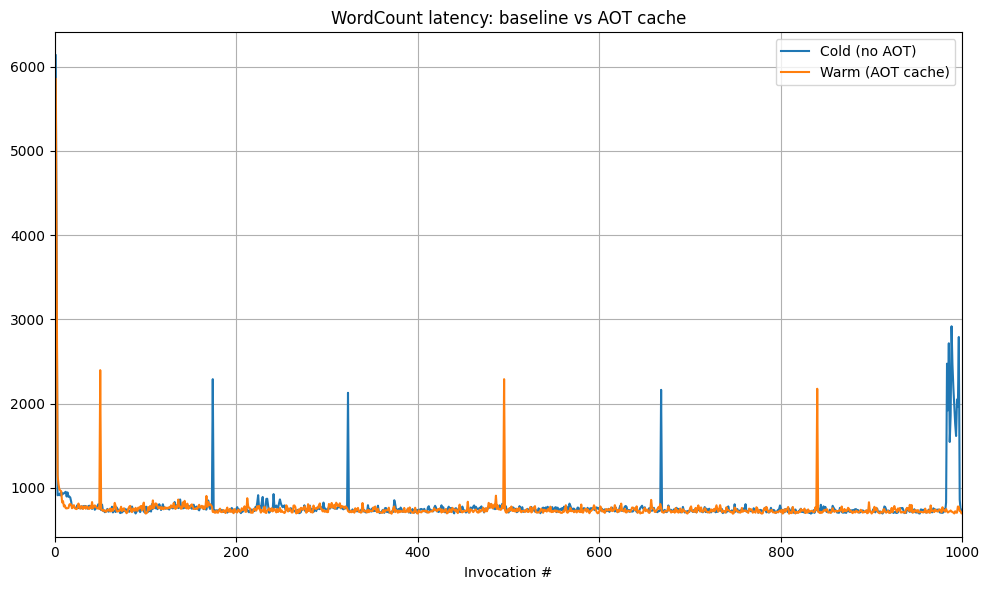


Cold:
  mean   : 756.2 µs
  median : 730.0 µs
  p95    : 789.0 µs

Warm:
  mean   : 748.6 µs
  median : 729.0 µs
  p95    : 814.0 µs


In [112]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(cold["invocation"], cold["time_us"], label="Cold (no AOT)")
plt.plot(warm["invocation"], warm["time_us"], label="Warm (AOT cache)")
# plt.plot(clean["invocation"], clean["time_us"], label="Clean (no flags)")
plt.xlabel("Invocation #")
plt.xlim(0, 1000)

plt.title("WordCount latency: baseline vs AOT cache")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Summary
def describe(df, label):
    print(f"\n{label}:")
    print(f"  mean   : {df['time_us'].mean():.1f} µs")
    print(f"  median : {df['time_us'].median():.1f} µs")
    print(f"  p95    : {df['time_us'].quantile(0.95):.1f} µs")

describe(cold, "Cold")
describe(warm, "Warm")
# describe(clean, "Clean")
